# PyTorch Quickstart
In this code tutorial we will learn how to quickly train a model to understand some of PyTorch's basic building blocks to train a deep learning model.
After completion of this tutorial, you should be able to import data, transform it, and efficiently feed the data in batches to a convolution neural network (CNN) model for image classification.

In [1]:
from google.colab import drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
    workspace = '/content/drive/MyDrive'
except:
    workspace = '.'
!pip install torch==1.7.0 torchvision==0.8.0 torchaudio==0.7.0
%pip install -U opencv-python
%pip install -U opencv-contrib-python

Mounted at /content/drive
     |████████████████████████████████| 776.7 MB 4.2 kB/s 
     |████████████████████████████████| 11.8 MB 19.9 MB/s 
     |████████████████████████████████| 7.6 MB 24.3 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.10.0+cu111
    Uninstalling torchaudio-0.10.0+cu111:
      Successfully uninstalled torchaudio-0.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.7.0 which 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [3]:
print(torch.__version__)

1.7.0


## Import The Data
The first step before training the model is to import the data. We take the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) as an example.

Besides importing the data, we will also do a few more things:
- We will tranform the data into tensors using the `transforms` module
- We will use `DataLoader` to build convenient data loaders or what are referred to as iterators, which makes it easy to efficiently feed data in batches to deep learning models. 
- As hinted above, we will also create batches of the data by setting the `batch` parameter inside the data loader. Notice we use batches of `32` in this tutorial but you can change it to `64` if you like. I encourage you to experiment with different batches.

In [4]:
BATCH_SIZE = 32

## transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

## download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

## download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


## Exploring the Data
Let's check what the train and test dataset contains.

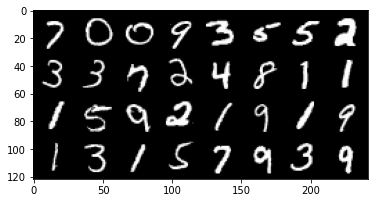

In [5]:
import matplotlib.pyplot as plt
import numpy as np

## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

## show images
imshow(torchvision.utils.make_grid(images))

Let's check the dimensions of a batch.

In [6]:
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])


## Import Customize Data
Besides the datasets provided by torchvision, you can import your own data and customize your **Dataloader**.
Here we take the Chinese character dataset used for assignment 2 as an example for customize dataset.

At first, let's import the data from directory at first, just same as previous tutorials.

In [7]:
# load the images
import os
import csv
import cv2
import numpy as np
from pprint import pprint
from collections import namedtuple
from matplotlib import pyplot as plt
root = os.path.join(workspace, 'assignment-2/')
label_path = os.path.join(root, 'label.csv')

 
def labels2strs(labels: list) -> list:
    lengths = np.max([[len(j) for j in i] for i in labels], axis=0)
    format_str = ' '.join(['{:^%ds}'%length for length in lengths])
    seps = ' '.join(['-'*length for length in lengths])
    contents = [format_str.format(*row) for row in labels]
    contents.insert(1, seps)
    return contents

if os.path.exists(label_path):
    with open(label_path) as f:
        flabels = list(csv.reader(f))
    # print(*labels2strs(flabels), sep='\n')
else:
    raise ValueError('Invalid label file path [%s]'%label_path)


samples = {'train': [], 'val': [], 'test': []}

class Sample:
    def __init__(self, idx=0, fname='', img=None, feat=None, label=None):
        self.idx = idx
        self.fname = fname
        self.img = img
        self.feat = feat
        self.label = label
        self.pred = None

for idx, fname, label, split in flabels[1:]:
    idx, label = int(idx), int(label)
    fpath = os.path.join(root, fname)
    if not os.path.isfile(fpath):
        raise ValueError('%s not found' % fpath)
    else:
        img = cv2.imread(fpath, cv2.IMREAD_COLOR)[..., ::-1]
        if idx == 0:
          H, W, C = img.shape
        else:
          img = cv2.resize(img, (W, H))
        
        # plt.imshow(img)
        
        samples[split].append(Sample(idx, fname, img, None, label))



In fact, the **samples** can be regarded as a simple version of dataloader which is a list contains all information we need and each element is a sample. 

Then we need to transform the samples list to a **torch.utils.data.Dataset** object. And load the Dataset object into Dataloader to make the data can be referred iteratively.

we only needs to define the class derivated from **torch.utils.data.Dataset**, which has three private functions:


    def __init__(self, loader=default_loader):

Initialize function, normally, you need to deifne a loader to preprocess the image, a images_path list and a target list. But here we already process the data and obtain a sample list, so we can simply translate it into Dataset.


    def __getitem__(self, index)：

This is a return function to return the image and label of given index. This is for the iterator.


    def __len__(self):

return the length of your whole data list which means the number of you dataset.


And then just translate the customize dataset object into Dataloader, then you can iteratively tranverse all data.

In [15]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    normalize
])

# define a loader to preprocess your image
def default_loader(img):
    img_tensor = preprocess(Image.fromarray(img))
    return img_tensor

class Trainset(Dataset):
    def __init__(self, loader=default_loader):
        self.samples = samples['train']
        self.loader = loader

    def __getitem__(self, index):
        sample = self.samples[index]
        img = self.loader(sample.img)
        label = sample.label
        return img, label

    def __len__(self):
        return len(self.samples)

c_trainset = Trainset(default_loader)
# shuffle paramter means whether to shuffle your dataset
c_trainloader = torch.utils.data.DataLoader(c_trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

class Testset(Dataset):
    def __init__(self, loader=default_loader):
        self.samples = samples['test']
        self.loader = loader

    def __getitem__(self, index):
        sample = self.samples[index]
        img = self.loader(sample.img)
        label = sample.label
        return img, label

    def __len__(self):
        return len(self.samples)

c_testset = Testset(default_loader)
c_testloader = torch.utils.data.DataLoader(c_testset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)


Let's check our customize train and test data loaders.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([3, 0, 1, 1, 1, 4, 2, 2, 0, 0, 0, 3, 3, 0, 2, 1, 4, 1, 4, 2, 0, 4, 3, 0,
        3, 2, 1, 0, 2, 0, 0, 1])


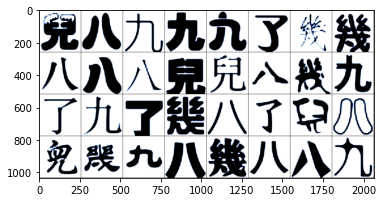

In [17]:
## get some random training images
c_dataiter = iter(c_trainloader)
c_images, c_labels = c_dataiter.next()

## show images
imshow(torchvision.utils.make_grid(c_images))
print(c_labels)

## Define Model
Now using the classical deep learning framework pipeline, let's build the 1 convolutional layer model. 

Here are a few notes for those who are beginning with PyTorch:
- The model below consists of an `__init__()` portion which is where you include the layers and components of the neural network. In our model, we have a convolutional layer denoted by `nn.Conv2d(...)`. We are dealing with an image dataset that is in a grayscale so we only need one channel going in, hence `in_channels=1`. We hope to get a nice representation of this layer, so we use `out_channels=32`. Kernel size is 3, and for the rest of parameters we use the default values which you can find [here](https://pytorch.org/docs/stable/nn.html?highlight=conv2d#conv2d). 
- We use 2 back to back dense layers or what we refer to as linear transformations to the incoming data. Notice for `d1` I have a dimension which looks like it came out of nowhere. 128 represents the size we want as output and the (`26*26*32`) represents the dimension of the incoming data. If you would like to find out how to calculate those numbers refer to the [PyTorch documentation](https://pytorch.org/docs/stable/nn.html?highlight=linear#conv2d). In short, the convolutional layer transforms the input data into a specific dimension that has to be considered in the linear layer. The same applies for the second linear transformation (`d2`) where the dimension of the output of the previous linear layer was added as `in_features=128`, and `10` is just the size of the output which also corresponds to the number of classes.
- After each one of those layers, we also apply an activation function such as `ReLU`. For prediction purposes, we then apply a `softmax` layer to the last transformation and return the output of that.  

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # 28x28x1 => 26x26x32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.d1 = nn.Linear(26 * 26 * 32, 128)
        self.d2 = nn.Linear(128, 10)

    def forward(self, x):
        # 32x1x28x28 => 32x32x26x26
        x = self.conv1(x)
        x = F.relu(x)

        # flatten => 32 x (32*26*26)
        x = x.flatten(start_dim = 1)

        # 32 x (32*26*26) => 32x128
        x = self.d1(x)
        x = F.relu(x)

        # logits => 32x10
        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        return out

As I have done in my previous tutorials, I always encourage to test the model with 1 batch to ensure that the output dimensions are what we expect. 

In [ ]:
## test the model with 1 batch
model = SimpleCNN()
for images, labels in trainloader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break

batch size: torch.Size([32, 1, 28, 28])
torch.Size([32, 10])


## Training the Model
Now we are ready to train the model but before that we are going to setup a loss function, an optimizer and a function to compute accuracy of the model. 

In [ ]:
learning_rate = 0.001
num_epochs = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SimpleCNN()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Then we define a function for calculating accuracy of the model prediction.

In [ ]:
## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

Now it's time for training.

In [ ]:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))        

Epoch: 0 | Loss: 1.6780 | Train Accuracy: 78.46
Epoch: 1 | Loss: 1.4937 | Train Accuracy: 97.05
Epoch: 2 | Loss: 1.4832 | Train Accuracy: 98.02
Epoch: 3 | Loss: 1.4786 | Train Accuracy: 98.45
Epoch: 4 | Loss: 1.4760 | Train Accuracy: 98.69


We can also compute accuracy on the testing dataset to see how well the model performs on the image classificaiton task. As you can see below, our basic CNN model is performing very well on the MNIST classification task.

In [ ]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 98.30


## Tensor
https://pytorch.org/tutorials/beginner/introyt/tensors_deeper_tutorial.html

#T-SNE

T-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

Normally, we will use TSNE() function in sklearn.manifold package to create a TSNE object and use its fit_transform() funciton to run the dimension reducing algorithm.

Here we take the digits datset from sklearn as an example to show the function of T-SNE.

Firstly, we load the digits data from sklearn.

(901, 64)


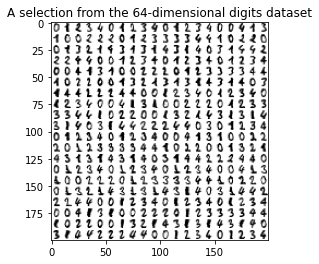

In [ ]:
from sklearn import datasets

digits = datasets.load_digits(n_class=5) 
X = digits.data
y = digits.target
print(X.shape) 
n_img_per_row = 20
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
  ix = 10 * i + 1
  for j in range(n_img_per_row):
    iy = 10* j + 1
    img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))
    plt.imshow(img, cmap=plt.cm.binary)
    plt.title('A selection from the 64-dimensional digits dataset')

Then we can use T-sne to reduce the dimention from 64 to 3.

Computing t-SNE embedding


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


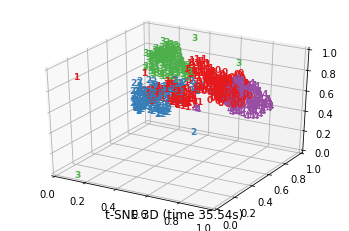

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
from time import time
import copy

print("Computing t-SNE embedding")
tsne = TSNE(n_components=3, init='pca', random_state=0)
t0 = time()
X_o = copy.deepcopy(X)
X_tsne = tsne.fit_transform(X)

def plot_embedding_3d(X, title=None):
  #x, y to [0,1]
  x_min, x_max = np.min(X,axis=0), np.max(X,axis=0)
  X = (X - x_min) / (x_max - x_min)
  #the reduced coordinate is（X[i, 0], X[i, 1],X[i,2]）
  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1, projection='3d')
  for i in range(X.shape[0]):
    ax.text(X[i, 0], X[i, 1], X[i,2],str(digits.target[i]), color=plt.cm.Set1(y[i] / 10.), fontdict={'weight': 'bold', 'size': 9})
    if title is not None:
      plt.title(title)

plot_embedding_3d(X_tsne,"t-SNE 3D (time %.2fs)" %(time() - t0))

You can also reduce the dimention to 2.

Computing t-SNE embedding


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


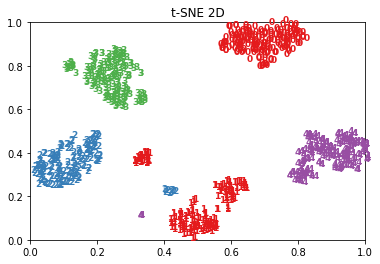

In [ ]:
print("Computing t-SNE embedding")
tsne = TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(X_o)

def plot_embedding_2d(X, title=None):
    #x, y to [0,1]
  x_min, x_max = np.min(X,axis=0), np.max(X,axis=0)
  X = (X - x_min) / (x_max - x_min)

  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)
  for i in range(X.shape[0]):
    ax.text(X[i, 0], X[i, 1], str(digits.target[i]), color=plt.cm.Set1(y[i] / 10.), fontdict={'weight': 'bold', 'size': 9})
    if title is not None:
      plt.title(title)
      
plot_embedding_2d(X_tsne,"t-SNE 2D")

#Seaborn
## Seaborn Versus Matplotlib

Here is an example of a simple random-walk plot in Matplotlib, using its classic plot formatting and colors.
We start with the typical imports:

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd

Now we create some random walk data:

In [ ]:
# Create some data
rng = np.random.RandomState(0)
x = np.linspace(0, 10, 500)
y = np.cumsum(rng.randn(500, 6), 0)

And do a simple plot:

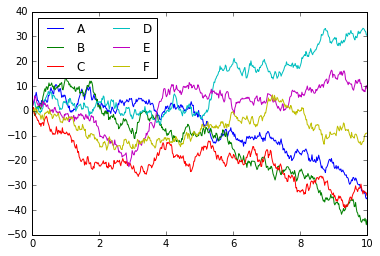

In [ ]:
# Plot the data with Matplotlib defaults
plt.plot(x, y)
plt.legend('ABCDEF', ncol=2, loc='upper left');

Although the result contains all the information we'd like it to convey, it does so in a way that is not all that aesthetically pleasing, and even looks a bit old-fashioned in the context of 21st-century data visualization.

Now let's take a look at how it works with Seaborn.
As we will see, Seaborn has many of its own high-level plotting routines, but it can also overwrite Matplotlib's default parameters and in turn get even simple Matplotlib scripts to produce vastly superior output.
We can set the style by calling Seaborn's ``set()`` method.
By convention, Seaborn is imported as ``sns``:

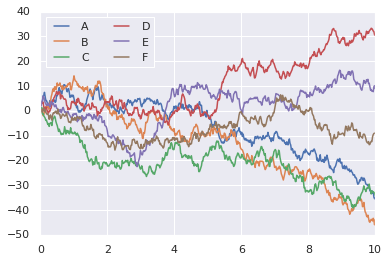

In [ ]:
import seaborn as sns
sns.set()
# same plotting code as above!
plt.plot(x, y)
plt.legend('ABCDEF', ncol=2, loc='upper left');

## Exploring Seaborn Plots

The main idea of Seaborn is that it provides high-level commands to create a variety of plot types useful for statistical data exploration, and even some statistical model fitting.

Let's take a look at a few of the datasets and plot types available in Seaborn. Note that all of the following *could* be done using raw Matplotlib commands (this is, in fact, what Seaborn does under the hood) but the Seaborn API is much more convenient.

### Histograms, KDE, and densities

Often in statistical data visualization, all you want is to plot histograms and joint distributions of variables.
We have seen that this is relatively straightforward in Matplotlib:

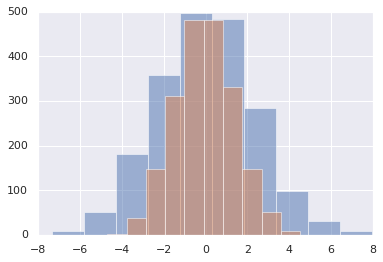

In [ ]:
data = np.random.multivariate_normal([0, 0], [[5, 2], [2, 2]], size=2000)
data = pd.DataFrame(data, columns=['x', 'y'])

for col in 'xy':
    plt.hist(data[col], alpha=0.5)

Rather than a histogram, we can get a smooth estimate of the distribution using a kernel density estimation, which Seaborn does with ``sns.kdeplot``:

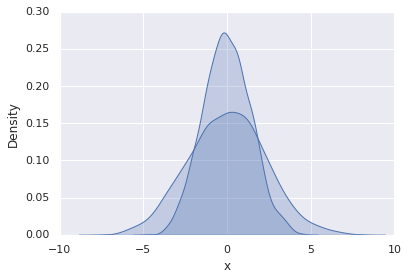

In [ ]:
for col in 'xy':
    sns.kdeplot(data[col], shade=True)

Histograms and KDE can be combined using ``distplot``:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


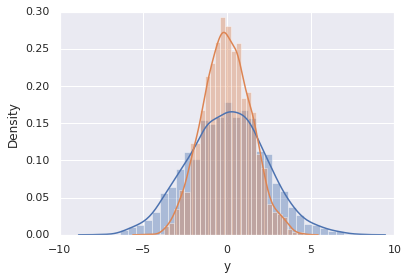

In [ ]:
sns.distplot(data['x'])
sns.distplot(data['y']);

##Scatterplot
In the tutorial, we used scatterplot() which can plot a map contains all scatter points. X and Y indicate the vertical and horizontal coordinates of the point. And hue specify how to classify the points with different colors, so we can assign labels to it.


In [ ]:
# draw the results using t-SNE, we can show the results using different features
# (this block is from Tutorial 4 and cannot run in this file)
from sklearn.manifold import TSNE
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 4)

print(X_tsne.shape)
sns.scatterplot(X=X_tsne[:,0], Y=X_tsne[:,1], hue=labels.flatten(), legend='full', palette=palette)